# Classifying cancer expression vectors

In this assignment you will train a neural network to identify the tissue type that produced an RNA expression vector. The dataset is comprised of RNA-seq data obtained from tumors. 

For a complete description of the data collection workflow see this page:
https://xenabrowser.net/datapages/?host=https://toil.xenahubs.net

And for the corresponding publication:
https://doi.org/10.1038/nbt.3772

In [ ]:
import sys
import numpy as np
from matplotlib import pyplot
import matplotlib.ticker as ticker
import pandas as pd
import h5py
import os
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

print("USING pytorch VERSION: ", torch.__version__)

USING pytorch VERSION:  1.13.1+cu116


## Loading and parsing training data
For this problem, expression data needs to be loaded and pruned. Initially, there are >50,000 genes in each expression vector, which can be reduced to a much smaller gene set for the sake of minimizing computation time. Here, the data is subsetted to only include genes from the KEGG gene set. You may want to consider reducing or expanding this dataset to get a better understanding of which genes are predictive, though this is not a requirement for the assignment.

For a list of gene sets, check out the MSigDB collections page: http://software.broadinstitute.org/gsea/msigdb/collections.jsp

This script was adapted from Rob Currie's ingestion script: https://github.com/rcurrie/tumornormal/blob/master/genesets.ipynb

We have placed a subset of this data for this homework in Google drive, you can download it here:

https://drive.google.com/drive/folders/1pPABQDEHCddPTJAhfD6G5KyBDJiK3unQ?usp=sharing

In [ ]:
# Load the data - If using Google drive link to access data the following with connect
# to drive, authenticate using your Google account and load the data

!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#x_test: https://drive.google.com/file/d/1Cc4zEw1wANFX8S44L87Rx_EZWwCcONMW/view?usp=sharing
#x_train: https://drive.google.com/file/d/1s8VvRaUc62OYukRunV689Y9u-v_y7KRl/view?usp=sharing
#y_test: https://drive.google.com/file/d/1W4Qdr3zm5QYGP5ncMQSurrO1m05KsKQ2/view?usp=sharing
#t_train: https://drive.google.com/file/d/1UmDZ25W84DmIY4im2XHCAc5QGgNkdexD/view?usp=sharing

# 2. Now proxy the Google Drive files to a local file
x_test_import = drive.CreateFile({'id':'1Cc4zEw1wANFX8S44L87Rx_EZWwCcONMW'})
x_train_import = drive.CreateFile({'id':'1s8VvRaUc62OYukRunV689Y9u-v_y7KRl'})
y_test_import = drive.CreateFile({'id':'1W4Qdr3zm5QYGP5ncMQSurrO1m05KsKQ2'})
y_train_import = drive.CreateFile({'id':'1UmDZ25W84DmIY4im2XHCAc5QGgNkdexD'})

x_test_import.GetContentFile('x_test.npz') # x_test.npz is the file name that will be accessible in the notebook.
x_train_import.GetContentFile('x_train.npz') # x_train.npz is the file name that will be accessible in the notebook.
y_test_import.GetContentFile('y_test.npz') # y_test.npz is the file name that will be accessible in the notebook.
y_train_import.GetContentFile('y_train.npz') # y_train.npz is the file name that will be accessible in the notebook.

y_index_key = {'Adipose Tissue': 0, 'Adrenal Gland': 1, 'Adrenal gland': 2, 'Bile duct': 3, 'Bladder': 4, 'Blood': 5, 'Blood Vessel': 6, 'Bone Marrow': 7, 'Brain': 8, 'Breast': 9, 'Cervix': 10, 'Cervix Uteri': 11, 'Colon': 12, 'Endometrium': 13, 'Esophagus': 14, 'Eye': 15, 'Fallopian Tube': 16, 'Head and Neck region': 17, 'Heart': 18, 'Kidney': 19, 'Lining of body cavities': 20, 'Liver': 21, 'Lung': 22, 'Lymphatic tissue': 23, 'Muscle': 24, 'Nerve': 25, 'Ovary': 26, 'Pancreas': 27, 'Paraganglia': 28, 'Pituitary': 29, 'Prostate': 30, 'Rectum': 31, 'Salivary Gland': 32, 'Skin': 33, 'Small Intestine': 34, 'Soft tissue,Bone': 35, 'Spleen': 36, 'Stomach': 37, 'SympatheticÊNervous System': 38, 'Testis': 39, 'Thymus': 40, 'Thyroid': 41, 'Thyroid Gland': 42, 'Uterus': 43, 'Vagina': 44, 'White blood cell': 45}

for name in y_index_key:
  print(name, y_index_key[name])

Adipose Tissue 0
Adrenal Gland 1
Adrenal gland 2
Bile duct 3
Bladder 4
Blood 5
Blood Vessel 6
Bone Marrow 7
Brain 8
Breast 9
Cervix 10
Cervix Uteri 11
Colon 12
Endometrium 13
Esophagus 14
Eye 15
Fallopian Tube 16
Head and Neck region 17
Heart 18
Kidney 19
Lining of body cavities 20
Liver 21
Lung 22
Lymphatic tissue 23
Muscle 24
Nerve 25
Ovary 26
Pancreas 27
Paraganglia 28
Pituitary 29
Prostate 30
Rectum 31
Salivary Gland 32
Skin 33
Small Intestine 34
Soft tissue,Bone 35
Spleen 36
Stomach 37
SympatheticÊNervous System 38
Testis 39
Thymus 40
Thyroid 41
Thyroid Gland 42
Uterus 43
Vagina 44
White blood cell 45


## Define a pytorch Dataset object to contain the training and testing data
Pytorch handles data shuffling and batch loading, as long as the user provides a "Dataset" class. This class is just a wrapper for your data that casts the data into pytorch tensor format and returns slices of the data. In this case, our data has been stored in numpy format, which conveniently pytorch has a method for converting to their native format.

In [ ]:
class PrimarySiteDataset(Dataset):
    def __init__(self, x_path, y_path, batch_size=None):
        x = np.load(x_path)['a']
        y = np.load(y_path)['a']

        x_dtype = torch.FloatTensor
        y_dtype = torch.FloatTensor     # for MSE Loss

        self.length = x.shape[0]

        self.x_data = torch.from_numpy(x).type(x_dtype)
        self.y_data = torch.from_numpy(y).type(y_dtype)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length

example dataset


In [ ]:
x_train_path = "x_train.npz"
y_train_path = "y_train.npz"
x_test_path = "x_test.npz"
y_test_path = "y_test.npz"
dataset_train = PrimarySiteDataset(x_path=x_train_path,
y_path=y_train_path)
dataset_test = PrimarySiteDataset(x_path=x_test_path,
y_path=y_test_path)

In [ ]:
# Print information on the train and test datasets
print('Train datapoints: ', len(dataset_train))
print('Test datapoints: ', len(dataset_test))
print('Input features: ', len(dataset_train[1][0]))
print('Output classes: ', len(dataset_train[1][1]))

Train datapoints:  15300
Test datapoints:  3826
Input features:  5172
Output classes:  46


# Part 1:

1. How many training examples are in the dataset?
  - There are 15,300 training examples in dataset.
2. What proportion (%) of the full dataset has been set aside for testing?
  - I found that 3826/(15300 + 3826) = 20% of the data will be used for testing
3. How many gene expression values will be used as input to classify each sample in the
dataset?
  - There will be 5172 input values used to classify each sample in dataset.
4. How many tissue types are there in the data labels?
  - There are 46 tissues types in the data labels.
5. When performing classification with a neural network, the output vector is an array with
n variables, where each variable describes the probability that your input belongs to one
class in your classification problem. Based on this information, what should be the size
of your output layer in the neural network?
  - Based on our given data, it seems like there are 46 tissue types, therefore, our vector size should be 46 for the output.
6. How will you know which index in the output corresponds to which tissue type once you
feed your data into the model and get your output?
  - By using the `y_index_key` from the above cells which load the data into this notebook, each tissues has a value which is the index. Therefore, using `y_index_key` will tell us which y values goes where.




# Part 2 & Part 3

## Flowchart of data:
Link: [google drive shared link](https://docs.google.com/drawings/d/1e9MEzpxIiuZmOJFIOLx7tjwYN1nkJhaClZK7jLOzF3k/edit?usp=sharing)
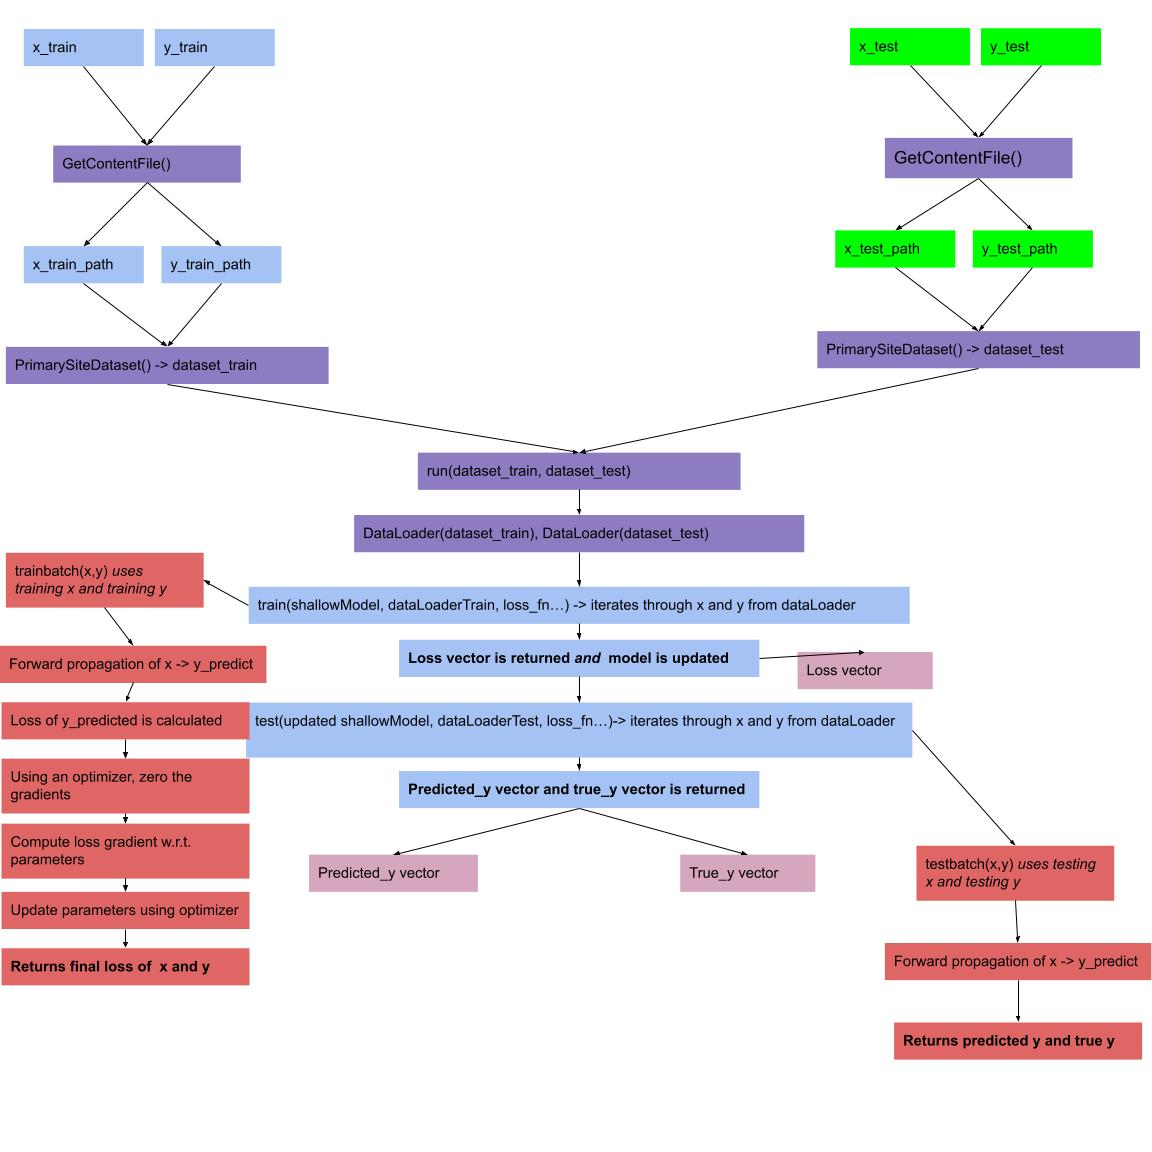

In [ ]:
def train_batch(model, x, y, optimizer, loss_fn):
    '''
    This function input the training data into the model. We first predict our
    y values, then we compute the loss based on our predicted y and the true
    y values. We optimize the gradient, back-propagate our loss function. Then
    lastly, we update the optimizer's parameters.

    Input:
      - model -> our learning model to use
      - x -> input data
      - y -> true y outputs
      - loss_fn -> function used to calculate our loss (i.e. MSE)
      - optimizer -> used to optimize ML gradient
    
    Output:
      - Returns final loss of batch
    '''
    ## Note, in practice pytorch can do this all for you in one step, but showing you here to be explicit
    
    # Run forward calculation
    y_predict = model.forward(x)

    # convert 1-hot vectors back into indices #part 4
    max_values, target_index = y.max(dim=1)
    target_index = target_index.type(torch.LongTensor)

    # Compute loss.
    loss = loss_fn(y_predict, target_index)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

    return loss.data.item()


In [ ]:
def train(model, loader, optimizer, loss_fn, epochs=5):
    '''
    This function trains all batches from the loader and reports each epoch
    and all batches tested.

    Inputs:
      model -> model used to train data
      loader -> loads all batches into the function
      optimizer -> used to optimize ML gradient
      loss_fn -> function used to calculate loss (i.e. MSE)
      epochs -> the number of iterations to run on our training data

    Output:
      - Returns a list of all the calculated loss values in each batch
    '''
    losses = list()

    batch_index = 0
    for e in range(epochs): # iterate through each epocj
        for x, y in loader: #go through each batch in loader
            loss = train_batch(model=model, x=x, y=y, optimizer=optimizer, loss_fn=loss_fn) #calc loss
            losses.append(loss) # append all the loss values into the list

            batch_index += 1

        print("Epoch: ", e+1)
        print("Batches: ", batch_index)

    return losses

In [ ]:
def test_batch(model, x, y):
    '''
    Tests a batch by using forward propagation in order to calculate predicted
    y values

    Input:
      - model -> model to use for ML
      - x -> input for test data
      - y -> true y values
    '''
    # run forward calculation
    y_predict = model.forward(x)

    return y, y_predict

In [ ]:
def test(model, loader):
    '''
    This function forward propagtes all batches into the ML model.

    Input:
      model -> model used for ML
      loader -> loads input data to use for testing

    Output:
      - A vector of predicted y_values
    '''
    y_vectors = list()
    y_predict_vectors = list()

    batch_index = 0
    for x, y in loader:
        y, y_predict = test_batch(model=model, x=x, y=y)

        y_vectors.append(y.data.numpy())
        #y_vectors.append(y)
        y_predict_vectors.append(y_predict.data.numpy())

        batch_index += 1

    y_predict_vector = np.concatenate(y_predict_vectors)

    return y_predict_vector, y_vectors

In [ ]:
def plot_loss(losses):
    '''
    This function plots the losses from a given function.

    Inputs:
      - losses -> loss vector
    '''
    fig = pyplot.gcf()
    fig.set_size_inches(8,6)
    ax = pyplot.axes()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    x_loss = list(range(len(losses)))
    pyplot.plot(x_loss, losses)
    pyplot.show()
    pyplot.close()

In [ ]:
class ShallowLinear(nn.Module):
    '''
    A simple, general purpose, fully connected network
    This is also what our model will look like.
    '''
    def __init__(self):
        # Perform initialization of the pytorch superclass
        super(ShallowLinear, self).__init__()
        
        # Define network layer dimensions
        D_in, H1, H2, D_out = [5172, 40, 40, 46]    # These numbers correspond to each layer: [input, hidden_1, output]
        
        # Define layer types
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)

    def forward(self, x):
        '''
        This method defines the network layering and activation functions
        '''
        x = self.linear1(x) # hidden layer
        x = torch.relu(x)       # activation function
        x = self.linear2(x) # hidden layer
        x = torch.relu(x)       # activation function
        y_prime = self.linear3(x) # output layer
        
        return y_prime


In [ ]:
def run(dataset_train, dataset_test, batch_size_train = 8, n_epochs = 20):
    '''
    This function runs the entire ML neural network. It essentially loads both the training
    and test data, initializes the optimizer, trains the training data, and then finally,
    predict the y values based on the testing data.

    Inputs:
      - dataset_train -> input of training data
      - dataset_test -> input of testing data
      - batch_size_train -> used to partition data based on the batch size
      - n_epochs -> number of iterations for gradient
    '''
    # Batch size is the number of training examples used to calculate each iteration's gradient
    
    
    data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size_train, shuffle=True)
    data_loader_test = DataLoader(dataset=dataset_test, batch_size=len(dataset_test), shuffle=False)
    
    # Define the hyperparameters
    learning_rate = 5e-5
    shallow_model = ShallowLinear()
    
    # Initialize the optimizer with above parameters
    optimizer = optim.Adam(shallow_model.parameters(), lr=learning_rate)

    # Define the loss function
    loss_fn = nn.CrossEntropyLoss()  # softmax()

    # Train and get the resulting loss per iteration
    loss = train(model=shallow_model, loader=data_loader_train, optimizer=optimizer, loss_fn=loss_fn, epochs=n_epochs)
    
    # Test and get the resulting predicted y values
    y_predict, true_y = test(model=shallow_model, loader=data_loader_test)

    return loss, y_predict, true_y

Epoch:  1
Batches:  3060
Epoch:  2
Batches:  6120
Epoch:  3
Batches:  9180
Epoch:  4
Batches:  12240
Epoch:  5
Batches:  15300
Epoch:  6
Batches:  18360
Epoch:  7
Batches:  21420
Epoch:  8
Batches:  24480
Epoch:  9
Batches:  27540
Epoch:  10
Batches:  30600
Epoch:  11
Batches:  33660
Epoch:  12
Batches:  36720
Epoch:  13
Batches:  39780
Epoch:  14
Batches:  42840
Epoch:  15
Batches:  45900
Epoch:  16
Batches:  48960
Epoch:  17
Batches:  52020
Epoch:  18
Batches:  55080
Epoch:  19
Batches:  58140
Epoch:  20
Batches:  61200



predicted y matrix size = 3826 x 46 (np format: (3826, 46))
true y matrix size = 3826 x 46 (np format: (3826, 46))
Final loss: 0.016905259445011325


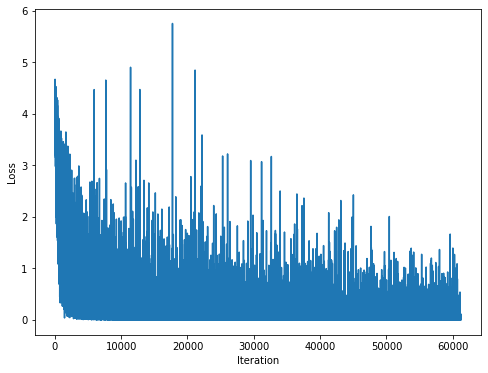

In [ ]:
losses, y_predict, true_y = run(dataset_train=dataset_train, dataset_test=dataset_test, batch_size_train=5)

print('\n\n')
print(f'predicted y matrix size = {len(y_predict)} x {len(y_predict[0])} (np format: {y_predict.shape})')
print(f'true y matrix size = {len(true_y[0])} x {len(true_y[0][0])} (np format: {true_y[0].shape})')

print("Final loss:", sum(losses[-100:])/100)  # Report the loss 
plot_loss(losses) # Plotting the loss function

# Part 3

1. The initial model will (probably) be so bad that you will be unable to use it as a starting
point. Perform some changes to your model architecture and training parameters until
your final loss is no longer undefined (nan). Don’t edit the loss function (we will do this
later in the assignment). Once your model consistently obtains a reasonable loss (usually
below 1) you can start working on assessing its performance. Describe the changes you
made.
  - I made no changes because I already get a final loss of less than one in the first place. The only thing I fiddled around with is the layer sizes in the ShallowLinear class.

2. Print the shapes of these arrays to
ensure they are exactly the same dimensions. What are their dimensions?
  - Both arrays have dimensions of 3826 x 46.

3. Do these match your test set size from part 1?
  - Based on the output, yes! The vectors defintely match the test size from **Part 1**.

In [ ]:
# question 3.4 
def training_table(y_pred, true_y, cut_output=sys.maxsize):
  '''
  Prints the predicted y values against the true y values

  Input:
    - y_pred -> numpy array of predicted y values
    - true_y -> list of true y values containing a numpy array
    - cut_output -> determines how many lines you want your output to be
  
  Output:
    Prints a table of predicted y values against the true y values
  '''
  print('y_predict y')
  
  # y = true_y[0]

  # line = 0
  # for y_prime, y_truth in zip(y_pred, y):
  #   for single_yPrime, single_yTruth in zip(y_prime, y_truth):
  #     if line >= cut_output:
  #       break
  #     line += 1
  #     print(f'{single_yPrime:0.3f} {single_yTruth}')
  
  y = true_y[0][0]
  y_prime = y_pred[0]

  for y_predicted, y_truth in zip(y_prime, y):
    print(f'{y_predicted:0.3f} {y_truth}')

In [ ]:
training_table(y_predict, true_y)

y_predict y
-9.269 0.0
-2.972 0.0
-4.830 0.0
-8.625 0.0
-13.482 0.0
-10.124 0.0
-0.087 0.0
-14.655 0.0
12.752 1.0
-5.177 0.0
-20.860 0.0
-5.082 0.0
-4.604 0.0
-15.464 0.0
-10.754 0.0
-6.618 0.0
-10.259 0.0
-15.501 0.0
0.696 0.0
-11.188 0.0
-4.925 0.0
-9.977 0.0
-22.553 0.0
-8.783 0.0
-3.805 0.0
-11.951 0.0
-8.333 0.0
-2.746 0.0
-0.159 0.0
1.592 0.0
-10.532 0.0
-14.067 0.0
-10.541 0.0
-15.019 0.0
-5.541 0.0
-6.999 0.0
-14.534 0.0
-11.313 0.0
-3.938 0.0
-8.218 0.0
-10.345 0.0
-12.734 0.0
-25.854 0.0
-4.340 0.0
-4.401 0.0
-22.431 0.0


In [ ]:
#3.5/3.6

def most_probably_y(y_pred, y_true, verbose=False):
  '''
  Based on the model, calculate the argmax values of predicted y and true y
  and analyze what the first values of predicted y argmax and true y argmax are
  then calculate the accuracy of model.

  input:
    - predicted y vector
    - true y vector
  
  output:
    - predicted y argmax
    - true y argmax
  '''
  y_pred_maxarg = np.argmax(y_pred, axis=1) # get argmax of predicted y values
  y_maxarg = np.argmax(y_true[0], axis=1) # get argmax of true y values
  if verbose:
    for y_p, y_t in zip(y_pred_maxarg, y_maxarg):
      print(f'{y_p} {y_t}')
  
  print(f'predicted y_argmax shape: {y_pred_maxarg.shape} \ntrue y_argmax shape: {y_maxarg.shape}')

  print(f'\ny_argmax[0] = {y_maxarg[0]} \ny_predict_argmax[0] = {y_pred_maxarg[0]}')

  print(f'In terms of table 4: y_true[0] = {y_true[0][0][y_maxarg[0]]} y_pred[0] = {y_pred[0][y_pred_maxarg[0]]:0.3f}')

  matches = 0

  for y_p, y_t in zip(y_pred_maxarg, y_maxarg): #3.6
    if y_p == y_t: #find matches between the predicted y argmax and the true y argmax
      matches += 1
  accuracy = (matches/len(y_maxarg)) * 100

  print(f'Accuracy of classification model: {accuracy:0.2f}%')
  
  return y_pred_maxarg, y_maxarg

In [ ]:
y_p, y_t = most_probably_y(y_predict, true_y, verbose=False)

predicted y_argmax shape: (3826,) 
true y_argmax shape: (3826,)

y_argmax[0] = 8 
y_predict_argmax[0] = 8
In terms of table 4: y_true[0] = 1.0 y_pred[0] = 12.752
Accuracy of classification model: 97.36%


5. Do you expect your y_predict argmax to match you truth set?
  - At this stage no, this is because we still haven't changed our architecture's loss function to accurately fit our data. Therefore, our y_predict argmax and truthset will not match most of the time.
6. What is your overall classification accuracy?
  - Based on what we can see, the overall classification accuracy (initally) is super low at 10.72%.

- Personal notes:
  - After changine hyper parameters and the loss function, the highest accuracy I recorded is roughly 97% while the lowest I found is at around 2.27%.

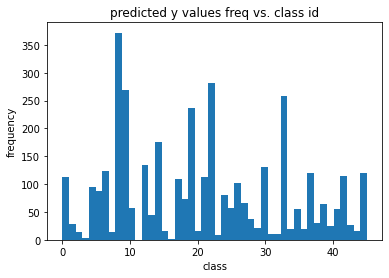

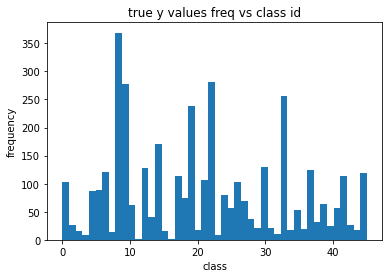

In [ ]:
#3.7

#predicted y values
pred_y_plot = pyplot.figure()
pred_y_axes = pyplot.axes()
pred_y_axes.set_title('predicted y values freq vs. class id')
pred_y_axes.set_ylabel('frequency')
pred_y_axes.set_xlabel('class')
pred_y_axes.hist(y_p, bins=46)

true_y_plot = pyplot.figure()
true_y_axes = pyplot.axes()
true_y_axes.set_title('true y values freq vs class id')
true_y_axes.set_xlabel('class')
true_y_axes.set_ylabel('frequency')
true_y_axes.hist(y_t, bins=46)

pyplot.show()

7. Plot a histogram of your argmax values for y, and for predicted y. How do they
compare? In which scenarios would you expect your predicted distribution to match or
not match your true distribution? 
  - Before changing the loss function, I saw that the true y and the predicted y histograms did not match this is because the accuracy is pretty low at the moment. The only time when both diagrams will match is when the accuracy of our model is extremely high. If both match this would mean that the model is predicting the our outputs accurately.

# Part 5

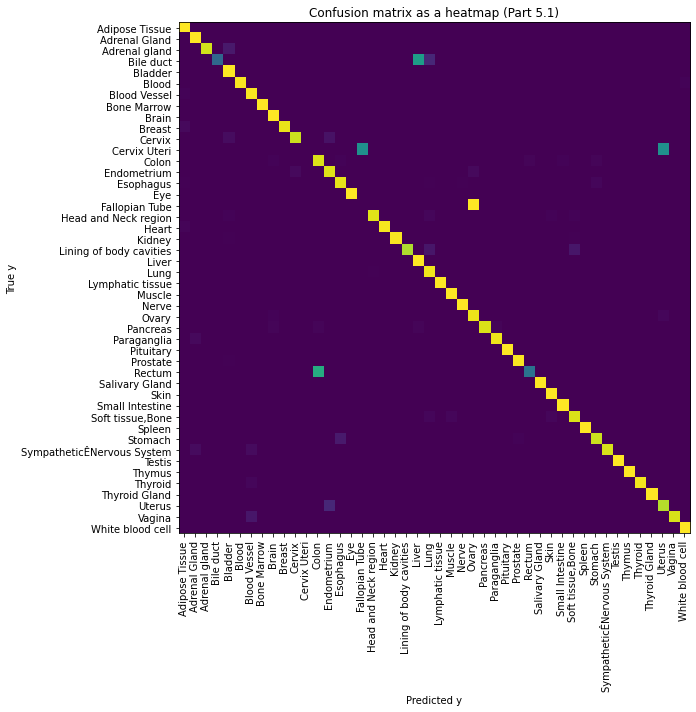

In [ ]:
#5.1 Confusion matrix
cm = confusion_matrix(y_t, y_p, normalize='true')
#print(cm)

def plot_heatmap(confusionMatrix):
  '''
  Plot a heat map of the confusion matrix

  input:
    - confusionMatrix -> a confusion matrix
  
  output:
    - heatmap version of confusion matrix
  '''
  fig, ax = pyplot.subplots(figsize=(10,10))
  heatmap = ax.imshow(confusionMatrix)

  ax.set_xticks(np.arange(len(y_index_key)), labels=y_index_key, rotation=90)
  ax.set_yticks(np.arange(len(y_index_key)), labels=y_index_key)

  ax.set_ylabel('True y')
  ax.set_xlabel('Predicted y')

  ax.set_title('Confusion matrix as a heatmap (Part 5.1)')
  
  fig.tight_layout()
  pyplot.show()

plot_heatmap(cm)

In [ ]:
accuracy_score(y_t, y_p)

0.9736016727652901

2. report how the data was processed (if
different from the provided script), your architecture, and your training parameters.
  - The data was proccessed the same way the script was given to us. Therefore, there are no changes as how the data was processed.
  - The data was given to the shallow linear neural network which was already provided to us. The only thing we had to change were the input layers and the output layers.
    - Furthermore, this model used the Shallow Linear architecture which is compromised of 2 hidden layers, an input size of 5172, and output size of 46.
  - The following are my training parameters:
    - learning rate -> `5e-5`
    - batch size -> `5`
    - optimizer -> Adam algorithm
    - model -> `Shallowlinear()`
    - epochs -> `20`
3. What is your final accuracy (overall percent)?
  - Based on when I re-ran all the cells, the final accuracy is `97.36`%.

In [ ]:
#5.4
print(np.diag(cm))
print(classification_report(y_t,y_p, target_names=y_index_key, zero_division=0))

[1.         1.         0.93333333 0.33333333 1.         0.98876404
 0.99173554 1.         0.99728997 0.9676259  0.91935484 0.
 0.9453125  0.95121951 0.96470588 1.         0.         0.95575221
 0.98666667 0.9916318  0.88235294 1.         0.9787234  1.
 1.         1.         0.97087379 0.94285714 0.97297297 1.
 0.99230769 0.38095238 1.         0.99610895 1.         0.94339623
 1.         0.92       0.9375     1.         1.         0.98214286
 1.         0.88888889 0.94117647 1.        ]
                            precision    recall  f1-score   support

            Adipose Tissue       0.91      1.00      0.95       103
             Adrenal Gland       0.93      1.00      0.96        26
             Adrenal gland       1.00      0.93      0.97        15
                 Bile duct       1.00      0.33      0.50         9
                   Bladder       0.93      1.00      0.96        87
                     Blood       1.00      0.99      0.99        89
              Blood Vessel      

4. What tissue types were most “confusing” for the model? Answer in terms of which
classes were most inter-confused, and quantitative accuracy for each of the most
confused classes.
  - Based on the Recall scores of each tissue, the following is a list of tissues that the model had difficulty on predicting correctly:
    - Bile duct
    - Rectum
    - Lining of body cavities
    - Cervix Uteri

5. How does each class’s frequency correlate (if at all) to the model’s performance for that
class, qualitatively or quantitatively?
  - Based on the the heat map and the classification report, a majority of the tissue frequency correlated with the model's performace. There are some negative correlation though with the above tissues that were considered confused with the model. A prime example of this is the Cervic Uteri where it there is a 0% recall rate and it doesn't even show up on the heat map.

6. Describe your strategy for choosing hyperparameters. Did you use any form of
evaluation to inform your decisions? If you have recorded the steps you took to reach
your final configuration, write them here.
  - For changing the hyper parameters, the only thing I changed was the learning rate. The only guidance I had with changing the parameters came from the neural network lecture that Prof. Paten gave out. From there, I started experimenting with the hyperparamters. I tried experimenting with different parameters and I found out that the smallest suggested learning rate gave me the highest accuracy and that the Adam() optimizer was the best optimizer for the model.

7. Assume you have a network with the following dimensions:

    1. Input: 32 nodes
    2. Hidden: 64 nodes
    3. Output: 4 nodes

  - What is the total number of weight parameters you are optimizing?
    - Based on our given input size, hidden layer size, and output size we can figure out our weight parameters with the following:
      - `32 * 64 + 64* 4 = 2304`
      - Therefore, we have 2,304 weighted parameters that we would need to optimize.

  - What is the total number of bias parameters you are optimizing?
    - In terms of bias parameters, we can solve it by the following:
      - `64*1 + 4 = 68`
      - Therefore, we have 68 bias parameters to optimize in the given network.

  - For your network, how many weight parameters are you optimizing? How does this
  compare to the number of training examples in your dataset?
    - In our own model, we can figure the number of weight paramters by the following:
    - `5172 * 40 + 40 * 40 + 40 * 46 = 210320` 
    - Therefore, we have 210,320 weighted parameters to optimize. From our input, we can see that we have 5,172 training example inputs in our dataset and in terms of our model, we can see that each input is going through 40 different nodes so this makes sense.

8.  Given these numbers, do you think there is any risk of overfitting? Considering the size
and diversity of this test set would you be confident that this model will generalize to all
future data you might encounter?
  - Based on our accuracy and the heatmap, I do not think there is a risk of overfitting. This is because our accuracy is fairly high *and* our runtime is fairly fast compared to other models most likely. Furthermore, I do not think our model is learning any noise from the training data. Rather, our model is perfectly compensates any noise there maybe in the test data. The 80% training, and 20% test split is pretty good on our model since it accurately predicts the test data. Personally, I fel like if we tried using a 70/30 split, then I fear that our model will be pretty accurate but it will be somewhat under-fitted. Therefore, for any future data given to us, I am confident that our model will predict the future data pretty well and it will not be over-fitted.

9. Do you think there is a better combination of hyperparameters (not model parameters)
with respect to the test results? Are there any obvious shortcomings in your opinion? If
you had infinite time/resources how might you improve your methods?
  - With how high our current accuracy is, I am completely satisfied with the hyperparameters that I currently have. Theoretically, there may be another combination of hyperparameters that may increase our accuracy to 98-99% but at this point in time, I cannot find a good combination of hyperparameters that can achieve that. However, we can only choose so many combinations of hyperparameters before our accuracy does not improve anymore. This is what is currently happening to me since I cannot find a good combination of hyperparameters that will consistently increase my accuracy score. If I had infinite time and resource, then I will most likely look into a different neural network architecture that will make my overall accuracy higher rather than changing my hyperparameters.
  
10. Other than the hyperparameters, what might affect this model’s performance?
  - Other than hyperparamters, I think the size of the data and the testing data may affect the performance and the accuracy of the model. For instance, if we had a 70/30 split, then we probably will be underfitting our model, or that will not be enough data to get accurate results from our test data. If we use something like a 90/10 split, then we will probably be *over-fitting* our model and our model will take into account noise when predicitng testing data.

11. You may have noticed that the “adrenal gland” tissue label is duplicated. If your model is
actually separating them, what might that indicate about its ability to generalize to new
“adrenal gland” tissue types?
  - In my model, we can see that it is seperating the 2 adrenal gland tissues. This is mainly because it is treating the two data sets as different tissues when in fact they are the same tissue. Furthermore, this means that we would need to update the adrenal gland parameters so we can predict the correct adrenal gland y values between the two classes. In order to do this, we can run a model that would tells us which is the "correct" adrenal gland tissue.